In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
from deeplkt.datasets.dataset import *
from torch.utils.data import DataLoader
from deeplkt.models.pure_lkt import PureLKTNet
from deeplkt.models.lkt_alexsobel import LKTAlexSobelNet

from deeplkt.models.lkt_vggsobel import LKTVGGSobelNet
from deeplkt.models.lkt_vggimproved import LKTVGGImproved
from deeplkt.models.base_model import BaseModel

from deeplkt.utils.util import dotdict
from deeplkt.utils.visualise import plot_different_results
from deeplkt.tracker.lkt_tracker import LKTTracker
from deeplkt.config import *

/home/sudeep/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sudeep/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sudeep/anaconda3/envs/pytorch/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sudeep/anaconda3/envs/pytorch/lib/pyt

In [4]:

use_cuda = torch.cuda.is_available()
print(use_cuda)
device = torch.device("cuda") if use_cuda else torch.device("cpu")



True


In [5]:
#!/usr/bin/env python
# coding: utf-8


# from pytorch_practise import *


vot_root_dir = '../../data/VOT/'
alov_root_dir = '../../data/ALOV/'


vot = VotDataset(os.path.join(vot_root_dir,
                       'VOT_images/'),
                 os.path.join(vot_root_dir,
                       'VOT_ann/'),
                 os.path.join(vot_root_dir,
                       'VOT_results/'), 
                 device)

alov = AlovDataset(os.path.join(alov_root_dir,
                       'ALOV_images/'),
                   os.path.join(alov_root_dir,
                       'ALOV_ann/'),
                   os.path.join(alov_root_dir,
                       'ALOV_results/'), 
                       device)


# train_loader = DataLoader(alov, batch_size=1, shuffle=False)



Parsing VOT dataset...
VOT dataset parsing done.
Total number of annotations in VOT dataset = 10188
Total number of videos in VOT dataset = 25
Parsing ALOV dataset...
ALOV dataset parsing done.
Total number of videos in ALOV dataset = 307
Total number of annotations in ALOV dataset = 15877


/home/sudeep/Documents/mtp/lkt/newCode/pytorch_updated


In [13]:
from deeplkt.config import *

train_params = dotdict({
    'batch_size' : BATCH_SIZE,
    'val_split' : VALIDATION_SPLIT,
    'train_examples':TRAIN_EXAMPLES,
    'shuffle_train': SHUFFLE_TRAIN,
    'random_seed': RANDOM_SEED,
    'lr': LR,
    'momentum': MOMENTUM,
    'l2': L2

})


params = dotdict({
    'mode' : MODE,
    'max_iterations' : MAX_LK_ITERATIONS,
    'epsilon' : EPSILON,
    'num_classes': NUM_CLASSES,
    'info': "VGGSobel LKT"
})

net = LKTVGGImproved(device, params)
tracker = LKTTracker(net)
learned_model = BaseModel(tracker, 'checkpoint', 'logs', train_params)
learned_model.load_checkpoint(44, best=True)

params = dotdict({
    'mode' : MODE,
    'max_iterations' : MAX_LK_ITERATIONS,
    'epsilon' : EPSILON,
    'info': "Pure LKT"
})
# lr = 0.0005
# momentum = 0.5

net = PureLKTNet(device, params)
tracker = LKTTracker(net)
pure_model = BaseModel(tracker, 'checkpoint', 'logs', train_params)




In [11]:

vot.visualise_sobels(19, 'Pure LKT', 'VGGSobel LKT')


In [6]:
for p in net.parameters():
    if(p.requires_grad):
        print(p.shape)


torch.Size([3, 1, 3, 3])
torch.Size([3, 1, 3, 3])


In [7]:
# print(net)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(net)


54000

In [16]:
pure_lkt = []
learned_lkt = []

for i in range(19, 20):
    pure_lkt.append(pure_model.eval_model(vot, i))
    learned_lkt.append(learned_model.eval_model(vot, i))

# for i in range(25):
#     learned_lkt.append(learned_model.eval_model(vot, i))

# results = {}
# results['pure-lkt'] = pure_lkt
# results['learned-lkt'] = learned_lkt

# plot_different_results(results, 'results.png')


Evaluating dataset for video  19
Total time taken =  6.840323448181152
Mean IOU =  0.7008703965130492
Evaluating dataset for video  19
Total time taken =  8.129767894744873
Mean IOU =  0.753041403944592


In [9]:
total = 0
pure_lkt_iou = 0
vgg_lkt_iou = 0

for i in range(25):
    pure_lkt_iou += pure_lkt[i] * vot.get_num_images(i) 
    vgg_lkt_iou += learned_lkt[i] * vot.get_num_images(i) 
    total += vot.get_num_images(i)
pure_lkt_iou /= total
vgg_lkt_iou /= total
print(pure_lkt_iou, vgg_lkt_iou)

0.826344702240398 0.8313393749349178


In [21]:
pure_lkt

[0.12341934347653223, 0.0369029711142952]

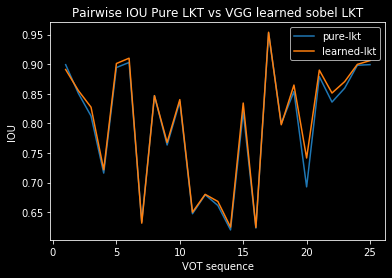

In [10]:

plot_different_results(results, 'results.png')